In [86]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import re

In [94]:
earmarks = pd.read_csv("data/earmarks.csv")
town_shapefiles = gpd.read_file("data/town_shapefile.shp")

earmarks.head()

,Earmark Description,Location,Amount,Administering State Agency,State Agency Contact,Account Number,Earmark Language
0,54th Massachusetts Reenactors and Historical S...,Boston,25000,MMP - Massachusetts Marketing Partnership,Phyllis.cahaly@mass.gov,70021530,"provided further that not less than $25,000 sh..."
1,A Street Pier Boat Ramp Rebuilding,Hull,150000,DCR - Department Of Conservation And Recreation,max.j.tassinari@mass.gov,15992031,"provided further, that not less than $150,000 ..."
2,Abigail Adams Historical Society,Weymouth,25000,ANF - Executive Office For Administration And ...,daniel.shark@mass.gov,15992058,"provided further, that not less than $25,000 s..."
3,Abington Housing Authority Upgrades,Abington,85000,DHCD - Dept Of Housing And Community Development,alain.fabo@mass.gov,70049318,"provided further, that not less than $85,000 s..."
4,Abington Utility Task Vehicle,Abington,28000,HED - Executive Office Of Economic Development,rory.c.ohanlon@mass.gov,15992043,"provided further, that not less than $28,000 s..."


In [91]:
population = pd.read_csv("data/ma_census/population.csv", header=1)
population = population.rename(columns={"Geographic Area Name": "city", " !!Total:": "population"}, errors="raise")
# print(population.head())
population = population.loc[:, ["city", "population"]]

new_names = {}
for c in population["city"]:
    if c == "Massachusetts":
        new_names[c] = "Massachusetts"
    else:
        new_name = re.sub(r"(( Town)? (city)|(Center)? (CDP))(, )?Massachusetts$", "", c) # Replaces "Massachusetts"
        new_names[c] = new_name
population = population.replace(new_names)
population

,city,population
0,Massachusetts,7029917
1,Abington,17062
2,Acushnet,3030
3,Adams,5466
4,Agawam,28692
...,...,...
244,Winthrop,19316
245,Woburn,40876
246,Woods Hole,834
247,Worcester,206518


In [22]:
# TODO: clean census towns from the census data cleaned above

,Earmark Description,Location,Amount,Administering State Agency,State Agency Contact,Account Number,Earmark Language
0,54th Massachusetts Reenactors and Historical S...,Boston,25000,MMP - Massachusetts Marketing Partnership,Phyllis.cahaly@mass.gov,70021530,"provided further that not less than $25,000 sh..."
1,A Street Pier Boat Ramp Rebuilding,Hull,150000,DCR - Department Of Conservation And Recreation,max.j.tassinari@mass.gov,15992031,"provided further, that not less than $150,000 ..."
2,Abigail Adams Historical Society,Weymouth,25000,ANF - Executive Office For Administration And ...,daniel.shark@mass.gov,15992058,"provided further, that not less than $25,000 s..."
3,Abington Housing Authority Upgrades,Abington,85000,DHCD - Dept Of Housing And Community Development,alain.fabo@mass.gov,70049318,"provided further, that not less than $85,000 s..."
4,Abington Utility Task Vehicle,Abington,28000,HED - Executive Office Of Economic Development,rory.c.ohanlon@mass.gov,15992043,"provided further, that not less than $28,000 s..."
...,...,...,...,...,...,...,...
858,Wrentham Public Water Supply,Wrentham,150000,DEP - Department Of Environmental Protection,steven.mccurdy@mass.gov,20000015,"provided further, that not less than $150,000 ..."
859,Youth Community Center in Georgetown,Georgetown,25000,HED - Executive Office Of Economic Development,rory.c.ohanlon@mass.gov,70100013,"provided further, that not less than $25,000 s..."
860,Youth Development in Lawrence,Lawrence,200000,LWD - Executive Office Of Labor And Workforce ...,sheila.l.tunney2@mass.gov,70100013,"provided further, that not less than $200,000 ..."
861,YWCA Funding,Statewide,4500000,HED - Executive Office Of Economic Development,rory.c.ohanlon@mass.gov,15992047,"and provided further, that not less than $4,50..."


In [41]:
median = earmarks["Amount"].median()
mean = earmarks["Amount"].mean()
stddev = earmarks["Amount"].std()
print(mean, stddev) # stddev)

402090.382387022 2103267.934430257


In [93]:
earmarks["Administering State Agency"].value_counts()
earmarks
# TODO: group by agency

,Earmark Description,Location,Amount,Administering State Agency,State Agency Contact,Account Number,Earmark Language
0,54th Massachusetts Reenactors and Historical S...,Boston,25000,MMP - Massachusetts Marketing Partnership,Phyllis.cahaly@mass.gov,70021530,"provided further that not less than $25,000 sh..."
1,A Street Pier Boat Ramp Rebuilding,Hull,150000,DCR - Department Of Conservation And Recreation,max.j.tassinari@mass.gov,15992031,"provided further, that not less than $150,000 ..."
2,Abigail Adams Historical Society,Weymouth,25000,ANF - Executive Office For Administration And ...,daniel.shark@mass.gov,15992058,"provided further, that not less than $25,000 s..."
3,Abington Housing Authority Upgrades,Abington,85000,DHCD - Dept Of Housing And Community Development,alain.fabo@mass.gov,70049318,"provided further, that not less than $85,000 s..."
4,Abington Utility Task Vehicle,Abington,28000,HED - Executive Office Of Economic Development,rory.c.ohanlon@mass.gov,15992043,"provided further, that not less than $28,000 s..."
...,...,...,...,...,...,...,...
858,Wrentham Public Water Supply,Wrentham,150000,DEP - Department Of Environmental Protection,steven.mccurdy@mass.gov,20000015,"provided further, that not less than $150,000 ..."
859,Youth Community Center in Georgetown,Georgetown,25000,HED - Executive Office Of Economic Development,rory.c.ohanlon@mass.gov,70100013,"provided further, that not less than $25,000 s..."
860,Youth Development in Lawrence,Lawrence,200000,LWD - Executive Office Of Labor And Workforce ...,sheila.l.tunney2@mass.gov,70100013,"provided further, that not less than $200,000 ..."
861,YWCA Funding,Statewide,4500000,HED - Executive Office Of Economic Development,rory.c.ohanlon@mass.gov,15992047,"and provided further, that not less than $4,50..."


In [52]:
mpc = earmarks["Location"].value_counts().rename_axis("Location").reset_index(name="counts")
mpc = pd.merge(mpc, earmarks.groupby("Location").sum()["Amount"], on="Location").sort_values(by="Amount", ascending=False)
mpc["Amount distributed by location"]

,Location,counts,Amount
2,Statewide,27,91655000
0,Boston,106,57670000
211,Norfolk County,1,50000000
26,Framingham,6,14050000
6,Lynn,12,5150000
...,...,...,...
253,Georgetown,1,25000
213,Groveland,1,21000
174,Halifax,1,20000
245,Merimack Valley,1,20000


Current total amount of earmarks distributed is around 350 million to various state agencies, probably not representative of all

Schools were also paid around $100 million in HVAC grants -- more in notes (TK)

<AxesSubplot:>

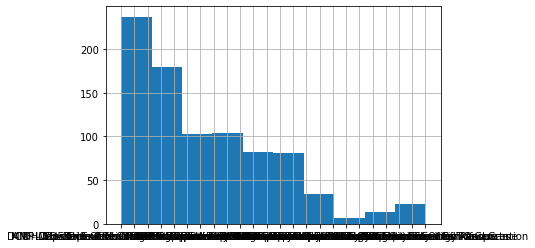

In [96]:
admin = pd.Series(earmarks["Administering State Agency"])
admin.hist()

In [ ]:
town_shapefiles.plot()